In [1]:
#general 
import pandas as pd
import numpy as np
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split

#warnings 
import warnings 
warnings.filterwarnings("ignore")

#for RNN
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


#for performance evaluation 
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix
from sklearn.metrics import precision_recall_fscore_support

#for visualization 
import matplotlib.pyplot as plt


2023-04-18 09:51:43.920046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Versions of Packages**

In [ ]:
#print("Pandas version:", pd.__version__)
#print("Scikit-learn version:", sklearn_version)
#print("NumPy version:", np.__version__)
#print("TensorFlow version:", tf.__version__)
#unable to find the version for pretty_conf_matrix, but maybe only one of us runs it?

In [2]:
#import pre-processed data from pickle 
year = "2010"
file_path = "/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/"
file_path_2 = "_final_rnn.pickle"

df_10= pd.read_pickle(file_path + year + file_path_2)
#df_09= pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2009_text_wo_names.pickle")
#df_11= pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2011_text_wo_names.pickle")
#df_12= pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2012_text_wo_names.pickle")
#df_13= pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2013_text_wo_names.pickle")
#df_14= pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2014_text_wo_names.pickle")
#df_15= pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2015_text_wo_names.pickle")
#df_16= pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2016_text_wo_names.pickle")
#df_17= pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2017_text_wo_names.pickle")
#df_18= pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2018_text_wo_names.pickle")
#df_19 = pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2019_text_wo_names.pickle")
#df_20 = pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2020_text_wo_names.pickle")
#df_21 = pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2021_text_wo_names.pickle")
#df_22 = pd.read_pickle(r"/Users/yolandaferreirofranchi/Desktop/ThesisDatasets/2022_text_wo_names_(1).pickle")
df_10

,pre_processed_sent,string_rnn,male_count,female_count,Proper_noun_list,pn exists,sentences,article_id,year,col_type
0,"[say, delight, restored, bridge, back, use]",say delight restored bridge back use,1,0,[Southease],None,"Chairman of Southease Parish, Neville Harrison...",1,2010,0
1,"[family, year, old, kill, house, fire, pay, tr...",family year old kill house fire pay tribute br...,0,2,[],None,The family of a 34-year-old mother from Bristo...,21,2010,1
2,"[family, say, kind, totally, dedicated]",family say kind totally dedicated,1,4,[],None,Her family said she was kind and a totally ded...,21,2010,1
3,"[truly, tragic, love, family, everything, give...",truly tragic love family everything give famil...,0,4,[Sara],None,"'Truly tragic'""Sara loved her family above eve...",21,2010,1
4,"[everybody, know, love, miss, always]",everybody know love miss always,0,3,[],None,"""Everybody who knew her will love her and miss...",21,2010,1
...,...,...,...,...,...,...,...,...,...,...
514542,"[contrast, news, conference, sound, guard, eve...",contrast news conference sound guard even slig...,2,0,[Fabio],None,Compare and contrast - Fabio Capello's news co...,2175804,2010,0
514543,"[goal, one, chosen, five, could, take, spot, k...",goal one chosen five could take spot kick need,2,0,"[Nelson, Mandela]",True,And after his goal at the Nelson Mandela Bay S...,2175804,2010,0
514544,"[everyone, practise, say]",everyone practise say,1,0,[],None,"""Everyone has been practising them,"" he said.",2175804,2010,0
514545,"[look, relax, hair, back, cornrows, mobile, tu...",look relax hair back cornrows mobile tuck righ...,4,0,[],None,"He looked relaxed, his hair back in cornrows, ...",2175804,2010,0


In [3]:
def absolute_count(male_col, female_col):
    if female_col > male_col and male_col == 0:
        return 1
    elif male_col> female_col and female_col ==0: 
        return 0
    else: 
        return None

In [4]:
#apply function to only get rows with an absolute count 
df_10['col_type'] = df_10.apply(lambda row: absolute_count(row['male_count'], row['female_count']),axis=1)

#remove nulls 
df_10 = df_10[df_10["col_type"].notnull()]

#DOC: number of male and female columns
df_10["col_type"].value_counts()  

0.0    378476
1.0    113870
Name: col_type, dtype: int64

**Split the DF**

In [5]:
# Split the df by the preprocessed 
x_train, x_test, y_train, y_test = train_test_split(df_10["pre_processed_sent"], 
                                                    df_10["col_type"], 
                                                    stratify = df_10["col_type"])

In [6]:
xTrain, xTest, yTrain, yTest = train_test_split(df_10["string_rnn"],
                                                df_10["col_type"], 
                                                stratify = df_10["col_type"])

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((xTrain, yTrain)) #string_rnn here 
test_dataset = tf.data.Dataset.from_tensor_slices((xTest, yTest)) #clean text 

In [ ]:
for example, gen_label in train_dataset.take(7):
  print('text: ', example.numpy())
  print('label: ', gen_label.numpy())

In [8]:
buffer_size = 50000 
batch_size = 64 # best practice
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
#map text features to integer sequences for all of the vocabulary
vocab_size = 60000 #this is 1/12 of all the words in the english language 
encoder = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
encoded_vocab = np.array(encoder.get_vocabulary())
vocab_dict = dict(enumerate(encoded_vocab))
#vocab_dict

**RNN/LSTM Architecture**

In [ ]:
rnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])

In [ ]:
#newmodel
rnn1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 256, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2)
])

In [11]:
#newmodel - BEST ONE SO FAR!!
rnn2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 256, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

In [28]:
#new2
rnn3 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 1024, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])

In [29]:
rnn3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 1024)        43911168  
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 256)        1180672   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                      

In [30]:
rnn3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
fitted_model = rnn3.fit(train_dataset, epochs=3,
                    validation_data=test_dataset, 
                    callbacks = [early_stop])

Epoch 1/3
5770/5770 [==============================] - 2098s 363ms/step - loss: 0.4867 - accuracy: 0.7847 - val_loss: 0.4611 - val_accuracy: 0.7952
Epoch 2/3
5770/5770 [==============================] - 2197s 381ms/step - loss: 0.4141 - accuracy: 0.8177 - val_loss: 0.4394 - val_accuracy: 0.8067
Epoch 3/3
5770/5770 [==============================] - 2322s 402ms/step - loss: 0.3558 - accuracy: 0.8447 - val_loss: 0.4387 - val_accuracy: 0.8169


In [48]:
from keras.models import load_model
model = rnn3
model.save(f"{model}")
loaded_model = load_model('rnn3')


INFO:tensorflow:Assets written to: <keras.engine.sequential.Sequential object at 0x7fd085c60430>/assets


INFO:tensorflow:Assets written to: <keras.engine.sequential.Sequential object at 0x7fd085c60430>/assets
2023-04-18 13:44:18.905371: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-18 13:44:19.546293: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-18 13:44:19.555848: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-18 13:44:19.575739: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-04-18 13:44:19.954261:

1/1 [==============================] - 2s 2s/step
[[-0.00356687 -0.04374368]]


In [57]:
#make predictions from saved model 
X_new = ['mean']
y_pred = loaded_model.predict(X_new)

#print the predictions
print("prediction of word {} for the negative class is: {}".format(X_new, y_pred[0, 0]))
print("prediction of word {} for the positive class is: {}".format(X_new, y_pred[0, 1]))  

1/1 [==============================] - 0s 27ms/step
prediction of word ['mean'] for the negative class is: -0.0035668686032295227
prediction of word ['mean'] for the positive class is: -0.04374368116259575


**Performance Evaluation**

In [32]:
def plot_graphs(fitted_model, metric):
  plt.plot(fitted_model.history[metric])
  plt.plot(fitted_model.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Text(0.5, 1.0, 'Loss')

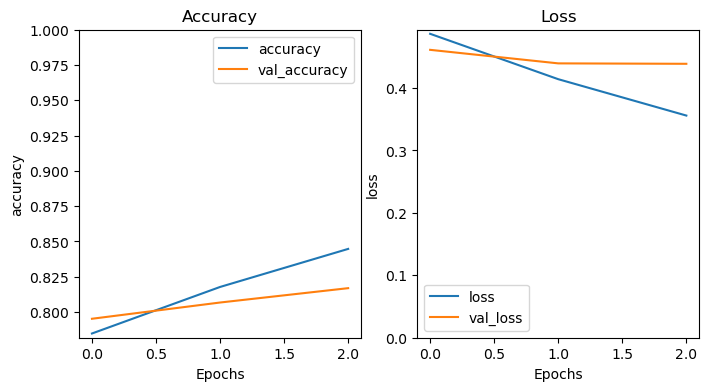

In [33]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plot_graphs(fitted_model, 'accuracy')
plt.ylim(None, 1)
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plot_graphs(fitted_model, 'loss')
plt.ylim(0, None)
plt.title("Loss")

**Confusion Matrix**

In [34]:
# Convert y_true and y_pred to numpy arrays
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred = np.concatenate([rnn3.predict(x).argmax(axis=-1) for x, _ in test_dataset], axis=0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

#define the positive class as the female class 
positive_class =1 

#define counts for each element of confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels = [0, positive_class]).ravel()
results_cm = {' ': ['True Negative', 'False Positive', 'False Negative', 'True Positive'],
           'Counts': [tn, fp, fn, tp]}

df_cm = pd.DataFrame(results_cm)
df_cm.set_index(' ', inplace=True)
print(df_cm)


1/1 [==============================] - 3s 3s/step
                Counts
                      
True Negative    89584
False Positive    5035
False Negative   17507
True Positive    10961


In [35]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, pos_label=1)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

Precision: [0.83652221 0.68523381]
Recall: [0.94678659 0.3850288 ]
F1 score: [0.8882455  0.49302807]


**Interpretation** we prove our HP that the model is worse in all evaluation performance metrics in predicting the first class 

In [ ]:
#make a cute confusion matrix 
data = pd.DataFrame(cm)
cmap = 'copper' #to change palette, look up cmap palettes
pp_matrix(data, cmap=cmap)

**Coefficient Analysis**

***For all layers***

In [37]:
# Get the feature weights
weights = rnn3.layers[1].get_weights()[0] #1 is what we have been using so farfor layers

# Sort the feature weights
sorted_weights = np.sort(weights, axis=0)[::-1]

# Select the top 1000 features
top_features = sorted_weights[:5000]

# Select the bottom 1000 features
bottom_features = sorted_weights[-5000:]

vocab_dict = dict(enumerate(encoded_vocab))

# Map the features back to words
top_words = encoded_vocab[np.argsort(weights[:,::-1])[:5000]]
bottom_words = encoded_vocab[np.argsort(weights)][:5000]


# top
s1h = pd.Series(top_words.ravel(), name='words') #ravel() to flatten 
s2h= pd.Series(top_features.ravel(), name='weights')
df_high = pd.concat([s1h, s2h], axis = 1)
#df_high

#bottom
#print("Bottom features:")#, top_words, type(top_features))
s1l = pd.Series(bottom_words.ravel(), name='words') #ravel() to flatten 
s2l= pd.Series(bottom_features.ravel(), name='weights')
df_low = pd.concat([s1l, s2l], axis = 1)

In [38]:
def remove_duplicates(df, column_name):
    unique_values = df[column_name].unique()
    rows_to_remove = []
    for value in unique_values:
        rows_with_value = df[df[column_name] == value]
        if len(rows_with_value) > 1:
            rows_to_remove += list(rows_with_value.iloc[1:].index)
    df = df.drop(rows_to_remove)
    df = df.reset_index(drop=True)
    return df

df_h = remove_duplicates(df_high, 'words')
df_l = remove_duplicates(df_low, 'words')

In [39]:
def remove_single_character_rows(df, column_name):
    mask = df[column_name].str.len() <= 2
    df_filtered = df[~mask]
    return df_filtered

df_h = remove_single_character_rows(df_h, 'words')
df_l = remove_single_character_rows(df_l, 'words')
df_l.sort_values(by = "weights", ascending=True)


,words,weights
287,deliver,-0.053157
940,place,-0.052866
924,detain,-0.052517
686,good,-0.052269
721,others,-0.052244
...,...,...
355,risk,-0.028850
674,murder,-0.028535
521,seat,-0.028344
218,end,-0.028283


In [ ]:
#sort highest
#df_sorted_h = df_high.sort_values(by = "weights", ascending=False)
#df_sorted_h

In [ ]:
#sort lowest
#df_sorted_l = df_low.sort_values(by = "weights", ascending=True)
#df_sorted_l.head(50)

**Word Cloud**

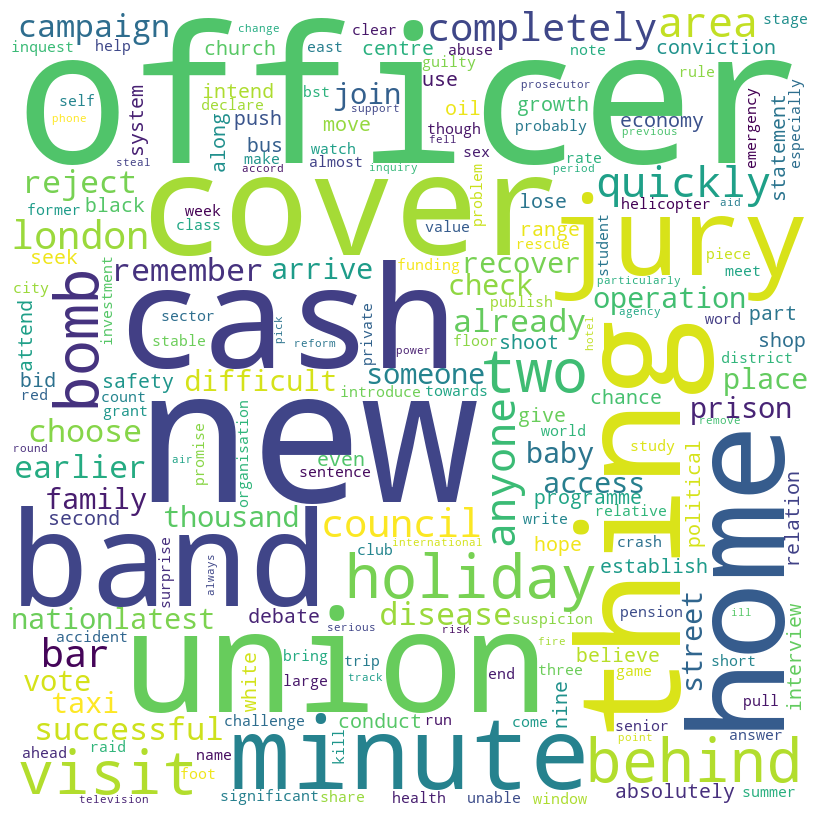

In [40]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df_h['words'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Code with Attention Mechanism**